In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.copy()

In [6]:
#umap
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [7]:
data_umap = m_data.groupby(['age','uuid']).mean().copy()
exp = data_umap.index.get_level_values('age').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('age').to_numpy()
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=42)

In [8]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

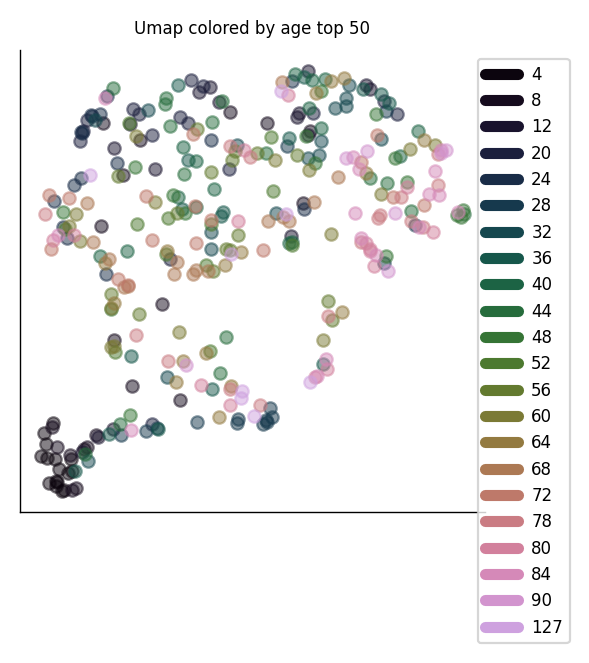

In [9]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 30)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by age top 50',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [10]:
## MI analysis 
from sklearn.datasets import make_regression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
X=data_umap
y=data_umap_labels
syll = X.columns.to_numpy()
#mutual_info=mutual_info_regression(X, y)
mutual_info=mutual_info_classif(X, y,discrete_features=True)

In [11]:
feature_importance = pd.Series(mutual_info,index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
print("Feature Importance:\n", feature_importance)

k = 20
selected_features = feature_importance.head(k).index.tolist()
print("\nSelected Features:", selected_features)

MI_umap = data_umap[selected_features].copy()

Feature Importance:
 33    3.072363
5     3.072363
26    3.072363
0     3.072363
3     3.072363
10    3.072363
24    3.072363
29    3.072363
16    3.072363
1     3.072363
35    3.072363
30    3.068200
2     3.068200
21    3.068200
8     3.068200
11    3.068200
15    3.068200
4     3.068200
19    3.068200
13    3.068200
28    3.068200
31    3.068200
7     3.068200
14    3.064037
18    3.064037
25    3.064037
6     3.064037
20    3.064037
38    3.064037
23    3.064037
9     3.064037
12    3.064037
36    3.064037
22    3.058302
27    3.056731
17    3.044034
32    3.043221
39    3.043221
34    2.993153
37    2.892108
dtype: float64

Selected Features: [33, 5, 26, 0, 3, 10, 24, 29, 16, 1, 35, 30, 2, 21, 8, 11, 15, 4, 19, 13]


In [12]:
# actual umap
coordinates = umap_embedding(MI_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=15,
        random_state=0)

In [13]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

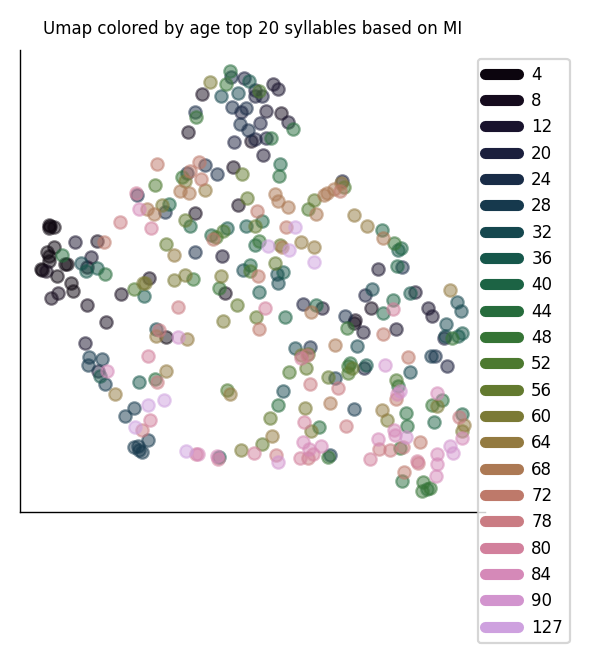

In [14]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 30)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by age top 20 syllables based on MI',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [15]:
## TSNE embedding

In [16]:
from sklearn.manifold import TSNE
X=data_umap
# Perform t-SNE analysis
tsne = TSNE(n_components=2, 
            perplexity=16, 
            n_iter=3000,
            metric = 'cosine',
            random_state=42)
coordinates = tsne.fit_transform(X)

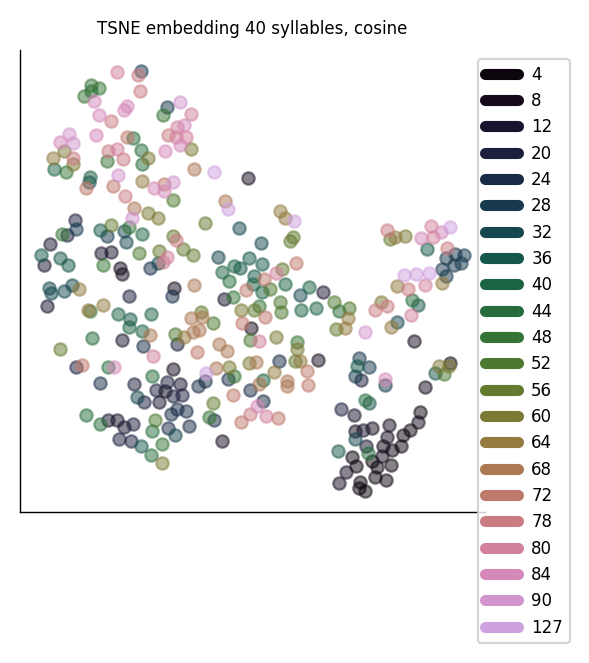

In [17]:
phasec = sns.color_palette("cubehelix", 30)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('TSNE embedding 40 syllables, cosine',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()

In [18]:
X=MI_umap
# Perform t-SNE analysis
tsne = TSNE(n_components=2, 
            perplexity=16, 
            n_iter=3000,
            metric = 'cosine',
            random_state=42)
coordinates = tsne.fit_transform(X)

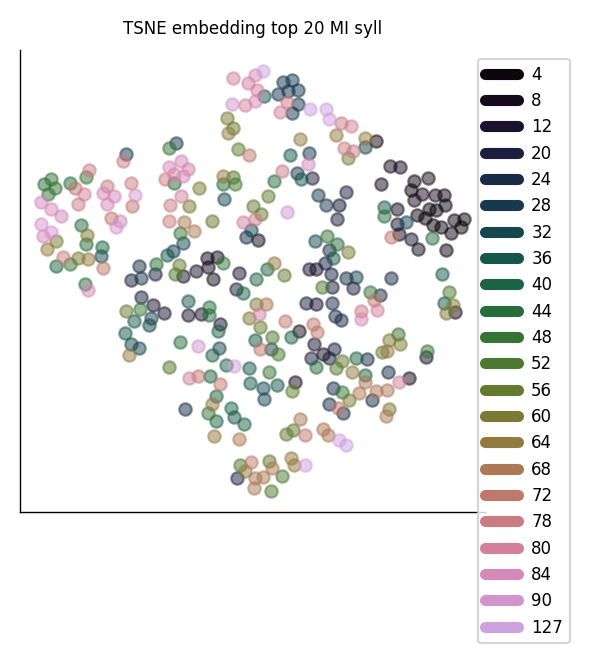

In [19]:
phasec = sns.color_palette("cubehelix", 30)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('TSNE embedding top 20 MI syll',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()

In [20]:
## isomap

In [21]:
from sklearn.manifold import Isomap

In [22]:
X=data_umap
n_neighbors = 5  # Adjust the number of neighbors
n_components = 2  
metric = 'cosine'
isomap = Isomap(n_neighbors=n_neighbors, 
                n_components=n_components,
               metric=metric,
               )
coordinates = isomap.fit_transform(X)

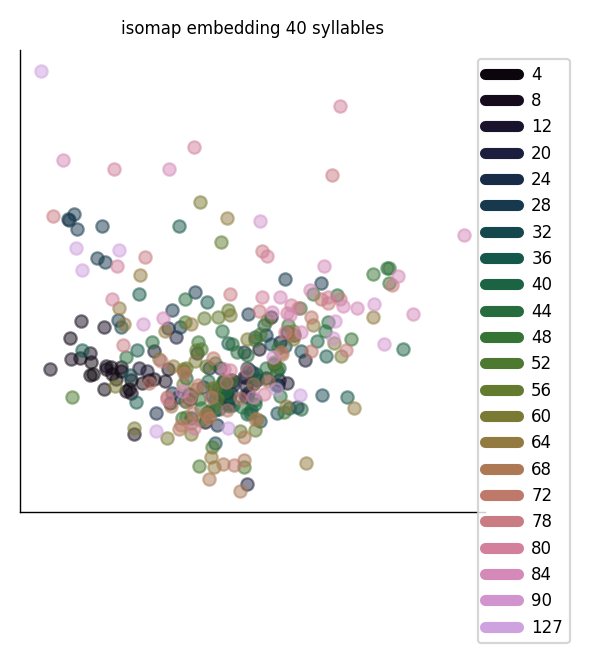

In [23]:
phasec = sns.color_palette("cubehelix", 30)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('isomap embedding 40 syllables',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()